In [24]:
import ROOT
from ROOT import gROOT, TCanvas, TF1, TFile, TTree, gRandom, TH1F

from ROOT import RooRealVar, RooFormulaVar, RooVoigtian, RooChebychev, RooArgList, \
                 RooArgSet, RooAddPdf, RooDataSet, RooCategory, RooSimultaneous, \
                 RooBreitWigner, RooCBShape, RooFFTConvPdf, RooGaussian,RooExponential, \
                 RooBinning, kRed, kBlue, kDotted,TString,RooAbsData, RooPlot, TCut, RooAbsData, RooFit                

In [25]:
# For debugging only
# %load_ext autoreload
# %autoreload 2

import sys
sys.path.append('/home/chasenberg/repos/dopy')

import ROOT

# Set LHCb plotting style
from dopy.doroot.lhcb_style import set_lhcb_style
set_lhcb_style()

# Enable plotting in notebooks
from dopy.doroot import rootnotes

# Import plotting functions and data reader from root_utils
from dopy.doroot.root_utils import (build_tchain_from_files, read_roodataset_from_tree,
                                    plot_simple, plot_pulls)

# Import configured models from doroot
from dopy.doroot.models import build_ipatia

In [3]:
import os 

#directories and files 
data_dir_2015 = '/fhgfs/users/chasenberg/data/2015/jpsiks/sweights/'
data_file_2015 ='Bd2JpsiKS_data_2015_flattened_SWeights.root'
data_dir_2016 = '/fhgfs/users/chasenberg/data/2016/jpsiks/sweights/'
data_file_2016 ='Bd2JpsiKS_data_2016_flattened_SWeights.root'

data_dir_2015 = os.path.join(data_dir_2015, data_file_2015)
data_dir_2016 = os.path.join(data_dir_2016, data_file_2016)

In [8]:
##############################################################
# Generate data and plot them via plot_simple and plot_pulls # 
##############################################################

rootfile_path = [data_dir_2015,data_dir_2016]
treename = 'Bd2JpsiKs'

mass = ROOT.RooRealVar('B0_FitDaughtersConst_M', 'mass', 5220, 5350, 'MeV/c^2')

my_vars = ROOT.RooArgSet(mass)

# Read TTree
tree = build_tchain_from_files(rootfile_path, treename)

# Create RooDataSet and fill it with data
dataset = ROOT.RooDataSet('dataset', 'dataset', my_vars)
read_roodataset_from_tree(tree, dataset, my_vars, show_progressbar=True)

In [19]:
# Construct signal from two Gaussian pdf's with different means and sigmas 
mean = RooRealVar("mean", "mean", 5280,  5200,5360)
sigma_1 = RooRealVar("sigma_1", "sigma_1", 15, 0, 30)
sigma_2 = RooRealVar("sigma_2", "sigma_2", 20, 0, 30)
sig1frac = RooRealVar("sig1frac","fraction of component 1 in signal",0.5,0.,1.)

signal_1 = RooGaussian("signal_1", "signal_1", mass, mean, sigma_1)
signal_2 = RooGaussian("signal_2", "signal_2", mass, mean, sigma_2)
signal = RooAddPdf("signal","signal",signal_1, signal_2,sig1frac)#,RooArgList(mean,sigma_1, sigma_2)) 
# Construct background pdfd
lambda_1= RooRealVar("lambda","lambda",0.0,-0.2,0.0)
background = RooExponential("background","background",mass,lambda_1)
# Construct composite pdf
nsig = RooRealVar("nsig", "nsig", 300000,0,1000000)#, 0, 100000)
nbkg = RooRealVar("nbkg", "nbkg", 1400000, 0, 2000000)
model = RooAddPdf("model", "model", RooArgList(signal, background), RooArgList(nsig, nbkg))

In [20]:
#Fit model to dataset
model.fitTo(dataset, ROOT.RooFit.Save(True)) 

<ROOT.RooFitResult object ("fitresult_model_dataset") at 0x22e7f570>

TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can


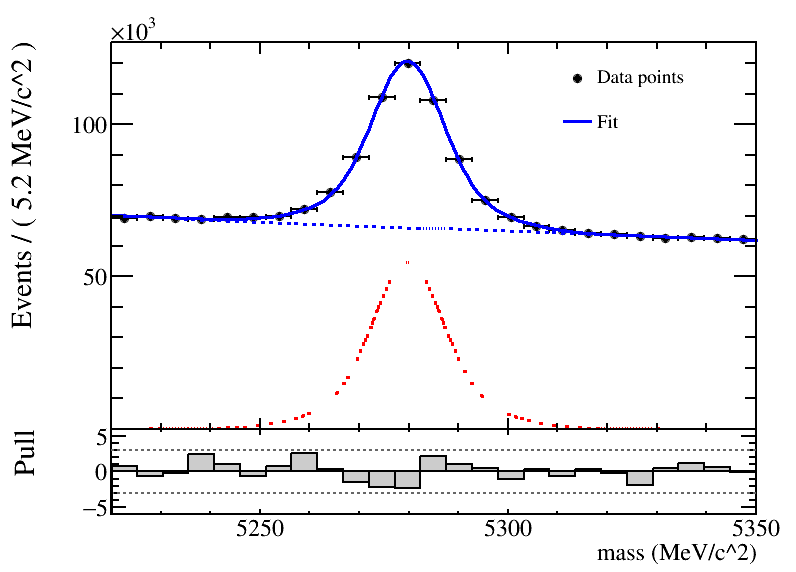

In [28]:
# Prepare frame
%matplotlib inline  
import sys
sys.path.append('/home/chasenberg/repos/root_utils/')
from ROOT import TColor
import rootnotes  # For displaying TCanvas in notebooks
from lhcb_style import set_lhcb_style # Set basic LHCb plot style
set_lhcb_style()   
from root_utils import plot_pulls
frame = mass.frame(ROOT.RooFit.Bins(25))

dataset.plotOn(frame, ROOT.RooFit.Name("data1"))

model.plotOn( frame , ROOT.RooFit.Components("signal"), ROOT.RooFit.LineStyle(kDotted), ROOT.RooFit.LineColor(kRed))
model.plotOn( frame , ROOT.RooFit.Components("background"), ROOT.RooFit.LineStyle(kDotted), ROOT.RooFit.LineColor(kBlue))
model.plotOn(frame, ROOT.RooFit.Name("fit"))
### Add additional informations to the plot
text_size = 0.035
# Create TLegend
legend = ROOT.TLegend(0.7, 0.75, 0.9, 0.9, '')
legend.AddEntry(frame.findObject('data1'), "Data points", "p");
legend.AddEntry(frame.findObject('fit'), 'Fit', 'l')
legend.SetTextSize(text_size)

# Create TLatex
'''latex = ROOT.TLatex(0.19, 0.8, '#splitline{Toy MC example}' + \
                                 '{#it{f}(x) = #frac{1}{#sigma #sqrt{2 #pi}}' + \
                                 ' e^{- 0.5 #left( #frac{x - #mu}{#sigma} #right)^{2}}}')'''
#latex.SetTextSize(text_size)

# Plot pulls
can, _ = plot_pulls('test', frame, legend=legend)#, latex=latex)
can.SaveAs("/home/chasenberg/repos/b2cc_sin2beta/notebooks/mass_fit/plots/jpsiks/2015_2016_merged/B0_Mass.pdf")
can  # To display plot in notebooks

In [22]:
from ROOT import RooStats

data_sweight = ROOT.RooStats.SPlot("sData","An SPlot", dataset,model, RooArgList(nsig, nbkg))
sWeight_sig =ROOT.RooDataSet("dataset_nsig","dataset_nsig", dataset, dataset.get(),"","nsig_sw")
sWeight_bkg = ROOT.RooDataSet("dataset_nbkg","dataset_nbkg", dataset, dataset.get(),"","nbkg_sw")